# This test is to be able to replicate the Original test T-001-LR-Epochs-FC-SHAP to confirm replicability and system performance across different computing hardware and python versions.


Here we test how Learning Rate, Epochs, and Dense Layer size impact SHAP calculations in a Neural Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\kregh\AppData\Local\Temp\ipykernel_37068\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
data = data.sample(n=10000)

In [9]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6961
1    1039
Name: count, dtype: int64
Test label
0    1760
1     240
Name: count, dtype: int64


In [10]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# Some error when sampling need to set to .values
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Networks

# Learning Rate at 5 Epochs

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_lr1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 136.22batch/s]


Epoch [1/5], Train Loss: 0.0692, Train Acc: 0.9762, Train F1: 0.9729


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 182.01batch/s]


Epoch [2/5], Train Loss: 0.0217, Train Acc: 0.9885, Train F1: 0.9883


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 183.08batch/s]


Epoch [3/5], Train Loss: 0.0212, Train Acc: 0.9882, Train F1: 0.9880


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 172.07batch/s]


Epoch [4/5], Train Loss: 0.0188, Train Acc: 0.9903, Train F1: 0.9902


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 178.57batch/s]


Epoch [5/5], Train Loss: 0.0168, Train Acc: 0.9923, Train F1: 0.9923


Testing: 100%|██████████| 16/16 [00:00<00:00, 242.95batch/s]


Test Loss: 0.0297, Test Accuracy: 0.9870, Test F1: 0.9867


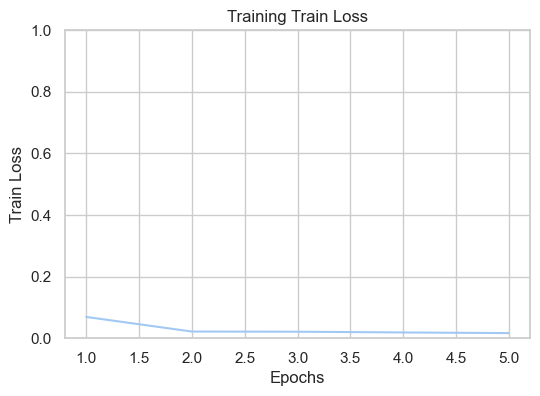

Epoch 1 Test


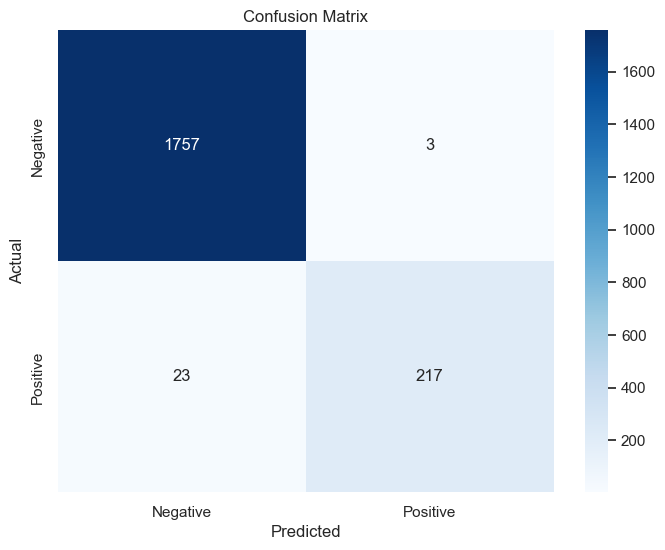

In [12]:
sampler = None
params = None
learning_rate = 0.1
epochs = 5
# Not saving.
save_factor = 100
model_lr1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_lr1.test(test_loader)
plot_metrics(model_lr1.train_loss, len(model_lr1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr1.test_predicted)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/smote/'
model_lr2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 180.07batch/s]


Epoch [1/5], Train Loss: 0.0899, Train Acc: 0.9628, Train F1: 0.9537


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 191.48batch/s]


Epoch [2/5], Train Loss: 0.0217, Train Acc: 0.9888, Train F1: 0.9887


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 186.62batch/s]


Epoch [3/5], Train Loss: 0.0205, Train Acc: 0.9890, Train F1: 0.9888


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 194.69batch/s]


Epoch [4/5], Train Loss: 0.0177, Train Acc: 0.9924, Train F1: 0.9924


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 189.68batch/s]


Epoch [5/5], Train Loss: 0.0176, Train Acc: 0.9919, Train F1: 0.9919


Testing: 100%|██████████| 16/16 [00:00<00:00, 185.18batch/s]


Test Loss: 0.0246, Test Accuracy: 0.9914, Test F1: 0.9914


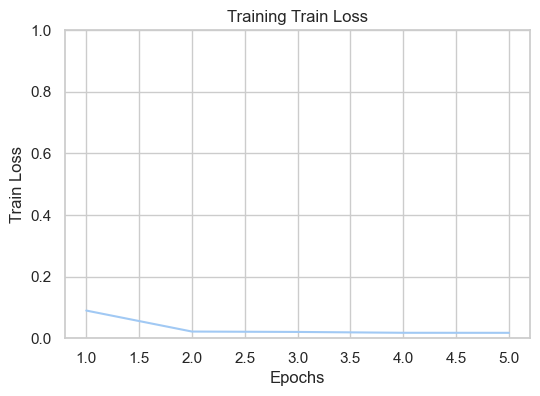

Epoch 1 Test


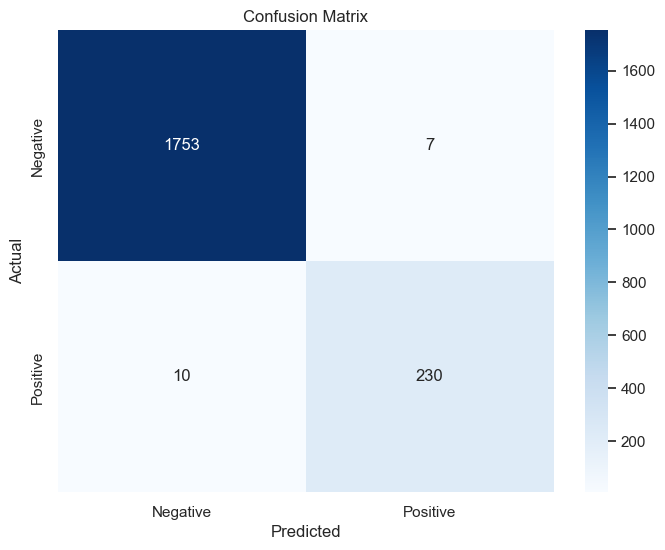

In [14]:
# SC - Needed to add store_data parameter to enable model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 5
# Not saving.
save_factor = 100
model_lr2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_lr2.test(test_loader)
plot_metrics(model_lr2.train_loss, len(model_lr2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr2.test_predicted)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_lr3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 191.23batch/s]


Epoch [1/5], Train Loss: 0.3467, Train Acc: 0.8960, Train F1: 0.8515


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 173.80batch/s]


Epoch [2/5], Train Loss: 0.0714, Train Acc: 0.9751, Train F1: 0.9741


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 180.49batch/s]


Epoch [3/5], Train Loss: 0.0383, Train Acc: 0.9814, Train F1: 0.9812


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 151.65batch/s]


Epoch [4/5], Train Loss: 0.0295, Train Acc: 0.9887, Train F1: 0.9887


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 159.12batch/s]


Epoch [5/5], Train Loss: 0.0255, Train Acc: 0.9896, Train F1: 0.9895


Testing: 100%|██████████| 16/16 [00:00<00:00, 222.06batch/s]


Test Loss: 0.0277, Test Accuracy: 0.9888, Test F1: 0.9888


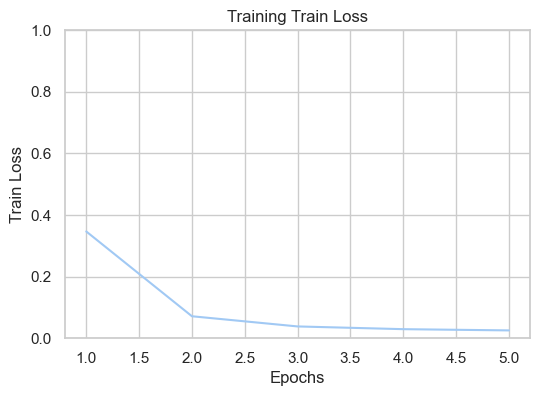

Epoch 1 Test


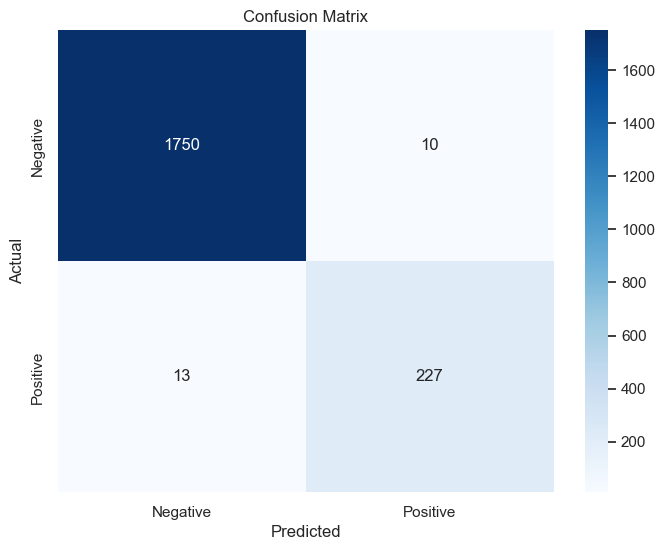

In [16]:
# SC - adjusted learning rate to 0.001 from 0.01, and added store_data = True
sampler = None
params = None
learning_rate = 0.001
epochs = 5
# Not saving.
save_factor = 100
model_lr3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_lr3.test(test_loader)
plot_metrics(model_lr3.train_loss, len(model_lr3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_lr3.test_predicted)

# Epochs at 0.01 Learning Rate

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 163.97batch/s]


Epoch [1/10], Train Loss: 0.0932, Train Acc: 0.9617, Train F1: 0.9520


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 153.00batch/s]


Epoch [2/10], Train Loss: 0.0230, Train Acc: 0.9892, Train F1: 0.9891


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 158.72batch/s]


Epoch [3/10], Train Loss: 0.0200, Train Acc: 0.9916, Train F1: 0.9915


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 147.76batch/s]


Epoch [4/10], Train Loss: 0.0182, Train Acc: 0.9914, Train F1: 0.9913


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 167.97batch/s]


Epoch [5/10], Train Loss: 0.0171, Train Acc: 0.9928, Train F1: 0.9927


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 177.26batch/s]


Epoch [6/10], Train Loss: 0.0165, Train Acc: 0.9932, Train F1: 0.9931


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 179.02batch/s]


Epoch [7/10], Train Loss: 0.0154, Train Acc: 0.9924, Train F1: 0.9924


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 174.76batch/s]


Epoch [8/10], Train Loss: 0.0158, Train Acc: 0.9928, Train F1: 0.9927


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 176.34batch/s]


Epoch [9/10], Train Loss: 0.0139, Train Acc: 0.9937, Train F1: 0.9936


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 174.65batch/s]


Epoch [10/10], Train Loss: 0.0150, Train Acc: 0.9923, Train F1: 0.9923


Testing: 100%|██████████| 16/16 [00:00<00:00, 216.68batch/s]


Test Loss: 0.0254, Test Accuracy: 0.9899, Test F1: 0.9898


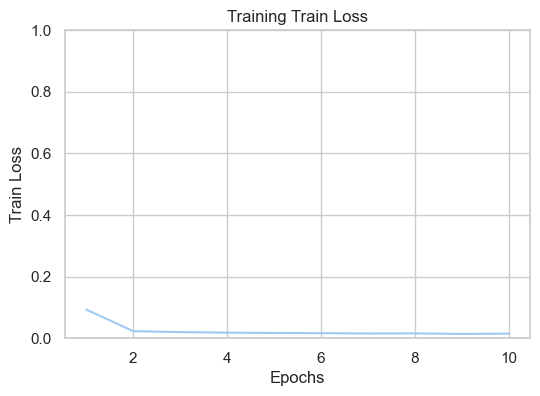

Epoch 1 Test


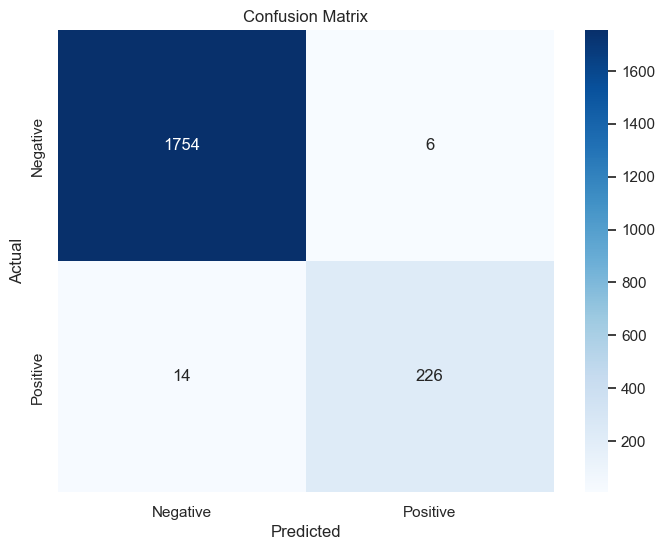

In [18]:
# SC - added store data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_ep1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_ep1.test(test_loader)
plot_metrics(model_ep1.train_loss, len(model_ep1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep1.test_predicted)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 156.63batch/s]


Epoch [1/50], Train Loss: 0.0904, Train Acc: 0.9654, Train F1: 0.9562


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 151.74batch/s]


Epoch [2/50], Train Loss: 0.0237, Train Acc: 0.9885, Train F1: 0.9884


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 162.29batch/s]


Epoch [3/50], Train Loss: 0.0191, Train Acc: 0.9913, Train F1: 0.9912


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 148.15batch/s]


Epoch [4/50], Train Loss: 0.0199, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 162.64batch/s]


Epoch [5/50], Train Loss: 0.0174, Train Acc: 0.9923, Train F1: 0.9922


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 178.74batch/s]


Epoch [6/50], Train Loss: 0.0164, Train Acc: 0.9928, Train F1: 0.9928


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 177.96batch/s]


Epoch [7/50], Train Loss: 0.0152, Train Acc: 0.9932, Train F1: 0.9931


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 177.60batch/s]


Epoch [8/50], Train Loss: 0.0144, Train Acc: 0.9929, Train F1: 0.9929


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 173.37batch/s]


Epoch [9/50], Train Loss: 0.0147, Train Acc: 0.9934, Train F1: 0.9934


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 176.49batch/s]


Epoch [10/50], Train Loss: 0.0145, Train Acc: 0.9936, Train F1: 0.9935


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 168.54batch/s]


Epoch [11/50], Train Loss: 0.0131, Train Acc: 0.9937, Train F1: 0.9936


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 144.51batch/s]


Epoch [12/50], Train Loss: 0.0122, Train Acc: 0.9945, Train F1: 0.9945


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 157.98batch/s]


Epoch [13/50], Train Loss: 0.0135, Train Acc: 0.9928, Train F1: 0.9928


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 165.20batch/s]


Epoch [14/50], Train Loss: 0.0133, Train Acc: 0.9933, Train F1: 0.9932


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 168.08batch/s]


Epoch [15/50], Train Loss: 0.0110, Train Acc: 0.9947, Train F1: 0.9946


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 164.84batch/s]


Epoch [16/50], Train Loss: 0.0099, Train Acc: 0.9958, Train F1: 0.9957


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 167.26batch/s]


Epoch [17/50], Train Loss: 0.0118, Train Acc: 0.9943, Train F1: 0.9943


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 145.14batch/s]


Epoch [18/50], Train Loss: 0.0094, Train Acc: 0.9957, Train F1: 0.9956


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 140.91batch/s]


Epoch [19/50], Train Loss: 0.0086, Train Acc: 0.9963, Train F1: 0.9963


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 145.54batch/s]


Epoch [20/50], Train Loss: 0.0086, Train Acc: 0.9965, Train F1: 0.9965


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 140.16batch/s]


Epoch [21/50], Train Loss: 0.0081, Train Acc: 0.9957, Train F1: 0.9956


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 142.07batch/s]


Epoch [22/50], Train Loss: 0.0084, Train Acc: 0.9967, Train F1: 0.9966


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 144.10batch/s]


Epoch [23/50], Train Loss: 0.0070, Train Acc: 0.9969, Train F1: 0.9969


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 152.82batch/s]


Epoch [24/50], Train Loss: 0.0068, Train Acc: 0.9968, Train F1: 0.9968


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 171.14batch/s]


Epoch [25/50], Train Loss: 0.0079, Train Acc: 0.9965, Train F1: 0.9965


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 159.11batch/s]


Epoch [26/50], Train Loss: 0.0071, Train Acc: 0.9968, Train F1: 0.9967


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 168.78batch/s]


Epoch [27/50], Train Loss: 0.0073, Train Acc: 0.9965, Train F1: 0.9965


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 169.03batch/s]


Epoch [28/50], Train Loss: 0.0068, Train Acc: 0.9967, Train F1: 0.9966


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 134.83batch/s]


Epoch [29/50], Train Loss: 0.0060, Train Acc: 0.9970, Train F1: 0.9970


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 142.64batch/s]


Epoch [30/50], Train Loss: 0.0054, Train Acc: 0.9974, Train F1: 0.9974


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 150.05batch/s]


Epoch [31/50], Train Loss: 0.0059, Train Acc: 0.9971, Train F1: 0.9971


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 144.18batch/s]


Epoch [32/50], Train Loss: 0.0055, Train Acc: 0.9976, Train F1: 0.9976


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 167.40batch/s]


Epoch [33/50], Train Loss: 0.0057, Train Acc: 0.9974, Train F1: 0.9974


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 161.15batch/s]


Epoch [34/50], Train Loss: 0.0063, Train Acc: 0.9970, Train F1: 0.9970


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 156.23batch/s]


Epoch [35/50], Train Loss: 0.0048, Train Acc: 0.9984, Train F1: 0.9984


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 155.84batch/s]


Epoch [36/50], Train Loss: 0.0044, Train Acc: 0.9978, Train F1: 0.9977


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 137.51batch/s]


Epoch [37/50], Train Loss: 0.0053, Train Acc: 0.9979, Train F1: 0.9979


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 149.43batch/s]


Epoch [38/50], Train Loss: 0.0041, Train Acc: 0.9980, Train F1: 0.9980


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 165.44batch/s]


Epoch [39/50], Train Loss: 0.0045, Train Acc: 0.9978, Train F1: 0.9977


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 159.66batch/s]


Epoch [40/50], Train Loss: 0.0048, Train Acc: 0.9975, Train F1: 0.9975


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 161.09batch/s]


Epoch [41/50], Train Loss: 0.0044, Train Acc: 0.9985, Train F1: 0.9985


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 147.97batch/s]


Epoch [42/50], Train Loss: 0.0073, Train Acc: 0.9964, Train F1: 0.9964


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 152.11batch/s]


Epoch [43/50], Train Loss: 0.0050, Train Acc: 0.9976, Train F1: 0.9976


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 165.63batch/s]


Epoch [44/50], Train Loss: 0.0039, Train Acc: 0.9985, Train F1: 0.9985


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 166.19batch/s]


Epoch [45/50], Train Loss: 0.0037, Train Acc: 0.9986, Train F1: 0.9986


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 161.17batch/s]


Epoch [46/50], Train Loss: 0.0057, Train Acc: 0.9975, Train F1: 0.9975


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 163.46batch/s]


Epoch [47/50], Train Loss: 0.0035, Train Acc: 0.9985, Train F1: 0.9985


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 145.79batch/s]


Epoch [48/50], Train Loss: 0.0031, Train Acc: 0.9985, Train F1: 0.9985


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 158.13batch/s]


Epoch [49/50], Train Loss: 0.0054, Train Acc: 0.9975, Train F1: 0.9975


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 141.17batch/s]


Epoch [50/50], Train Loss: 0.0033, Train Acc: 0.9988, Train F1: 0.9988


Testing: 100%|██████████| 16/16 [00:00<00:00, 190.82batch/s]

Test Loss: 0.0690, Test Accuracy: 0.9878, Test F1: 0.9878


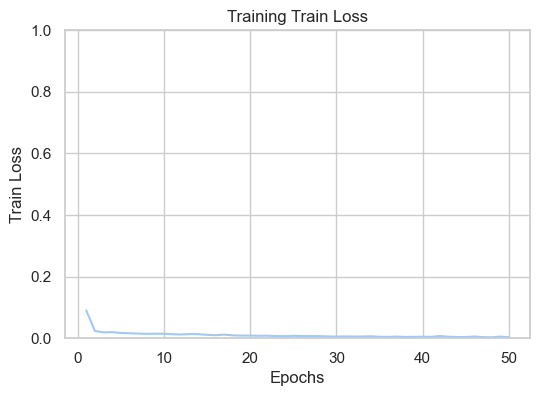

Epoch 1 Test


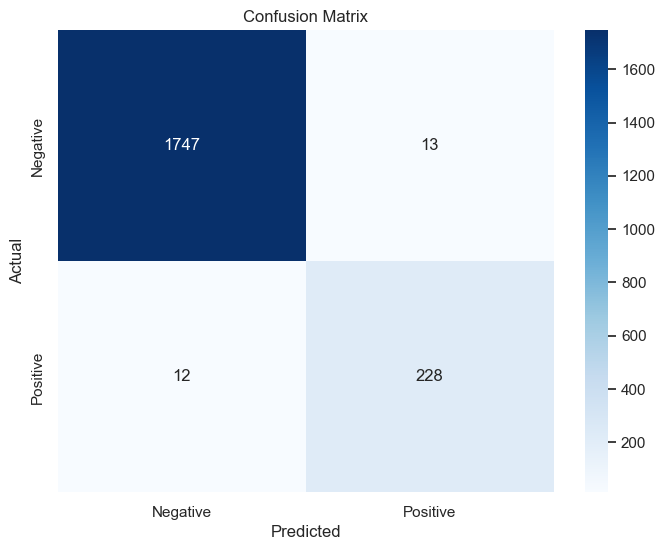

In [20]:
# SC - added store_data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 50
# Not saving.
save_factor = 100
model_ep2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_ep2.test(test_loader)
plot_metrics(model_ep2.train_loss, len(model_ep2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep2.test_predicted)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_ep3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/100: 100%|██████████| 63/63 [00:00<00:00, 160.22batch/s]


Epoch [1/100], Train Loss: 0.0913, Train Acc: 0.9656, Train F1: 0.9567


Epoch 2/100: 100%|██████████| 63/63 [00:00<00:00, 174.84batch/s]


Epoch [2/100], Train Loss: 0.0229, Train Acc: 0.9897, Train F1: 0.9897


Epoch 3/100: 100%|██████████| 63/63 [00:00<00:00, 142.80batch/s]


Epoch [3/100], Train Loss: 0.0198, Train Acc: 0.9914, Train F1: 0.9914


Epoch 4/100: 100%|██████████| 63/63 [00:00<00:00, 163.40batch/s]


Epoch [4/100], Train Loss: 0.0181, Train Acc: 0.9918, Train F1: 0.9918


Epoch 5/100: 100%|██████████| 63/63 [00:00<00:00, 164.13batch/s]


Epoch [5/100], Train Loss: 0.0166, Train Acc: 0.9927, Train F1: 0.9926


Epoch 6/100: 100%|██████████| 63/63 [00:00<00:00, 175.36batch/s]


Epoch [6/100], Train Loss: 0.0163, Train Acc: 0.9923, Train F1: 0.9922


Epoch 7/100: 100%|██████████| 63/63 [00:00<00:00, 150.63batch/s]


Epoch [7/100], Train Loss: 0.0158, Train Acc: 0.9933, Train F1: 0.9933


Epoch 8/100: 100%|██████████| 63/63 [00:00<00:00, 151.48batch/s]


Epoch [8/100], Train Loss: 0.0154, Train Acc: 0.9934, Train F1: 0.9934


Epoch 9/100: 100%|██████████| 63/63 [00:00<00:00, 171.31batch/s]


Epoch [9/100], Train Loss: 0.0151, Train Acc: 0.9928, Train F1: 0.9927


Epoch 10/100: 100%|██████████| 63/63 [00:00<00:00, 176.58batch/s]


Epoch [10/100], Train Loss: 0.0136, Train Acc: 0.9933, Train F1: 0.9932


Epoch 11/100: 100%|██████████| 63/63 [00:00<00:00, 176.02batch/s]


Epoch [11/100], Train Loss: 0.0135, Train Acc: 0.9931, Train F1: 0.9930


Epoch 12/100: 100%|██████████| 63/63 [00:00<00:00, 177.54batch/s]


Epoch [12/100], Train Loss: 0.0129, Train Acc: 0.9937, Train F1: 0.9936


Epoch 13/100: 100%|██████████| 63/63 [00:00<00:00, 170.08batch/s]


Epoch [13/100], Train Loss: 0.0134, Train Acc: 0.9931, Train F1: 0.9930


Epoch 14/100: 100%|██████████| 63/63 [00:00<00:00, 166.97batch/s]


Epoch [14/100], Train Loss: 0.0121, Train Acc: 0.9948, Train F1: 0.9948


Epoch 15/100: 100%|██████████| 63/63 [00:00<00:00, 165.60batch/s]


Epoch [15/100], Train Loss: 0.0112, Train Acc: 0.9947, Train F1: 0.9946


Epoch 16/100: 100%|██████████| 63/63 [00:00<00:00, 166.46batch/s]


Epoch [16/100], Train Loss: 0.0104, Train Acc: 0.9958, Train F1: 0.9957


Epoch 17/100: 100%|██████████| 63/63 [00:00<00:00, 157.10batch/s]


Epoch [17/100], Train Loss: 0.0096, Train Acc: 0.9955, Train F1: 0.9955


Epoch 18/100: 100%|██████████| 63/63 [00:00<00:00, 167.95batch/s]


Epoch [18/100], Train Loss: 0.0113, Train Acc: 0.9944, Train F1: 0.9944


Epoch 19/100: 100%|██████████| 63/63 [00:00<00:00, 165.60batch/s]


Epoch [19/100], Train Loss: 0.0096, Train Acc: 0.9962, Train F1: 0.9961


Epoch 20/100: 100%|██████████| 63/63 [00:00<00:00, 170.00batch/s]


Epoch [20/100], Train Loss: 0.0090, Train Acc: 0.9953, Train F1: 0.9953


Epoch 21/100: 100%|██████████| 63/63 [00:00<00:00, 167.55batch/s]


Epoch [21/100], Train Loss: 0.0087, Train Acc: 0.9962, Train F1: 0.9961


Epoch 22/100: 100%|██████████| 63/63 [00:00<00:00, 143.31batch/s]


Epoch [22/100], Train Loss: 0.0081, Train Acc: 0.9962, Train F1: 0.9961


Epoch 23/100: 100%|██████████| 63/63 [00:00<00:00, 154.14batch/s]


Epoch [23/100], Train Loss: 0.0082, Train Acc: 0.9957, Train F1: 0.9956


Epoch 24/100: 100%|██████████| 63/63 [00:00<00:00, 172.51batch/s]


Epoch [24/100], Train Loss: 0.0078, Train Acc: 0.9967, Train F1: 0.9966


Epoch 25/100: 100%|██████████| 63/63 [00:00<00:00, 169.54batch/s]


Epoch [25/100], Train Loss: 0.0070, Train Acc: 0.9971, Train F1: 0.9971


Epoch 26/100: 100%|██████████| 63/63 [00:00<00:00, 165.25batch/s]


Epoch [26/100], Train Loss: 0.0078, Train Acc: 0.9967, Train F1: 0.9966


Epoch 27/100: 100%|██████████| 63/63 [00:00<00:00, 171.26batch/s]


Epoch [27/100], Train Loss: 0.0069, Train Acc: 0.9968, Train F1: 0.9968


Epoch 28/100: 100%|██████████| 63/63 [00:00<00:00, 152.80batch/s]


Epoch [28/100], Train Loss: 0.0076, Train Acc: 0.9967, Train F1: 0.9966


Epoch 29/100: 100%|██████████| 63/63 [00:00<00:00, 156.47batch/s]


Epoch [29/100], Train Loss: 0.0062, Train Acc: 0.9969, Train F1: 0.9969


Epoch 30/100: 100%|██████████| 63/63 [00:00<00:00, 169.46batch/s]


Epoch [30/100], Train Loss: 0.0062, Train Acc: 0.9970, Train F1: 0.9970


Epoch 31/100: 100%|██████████| 63/63 [00:00<00:00, 168.10batch/s]


Epoch [31/100], Train Loss: 0.0079, Train Acc: 0.9960, Train F1: 0.9960


Epoch 32/100: 100%|██████████| 63/63 [00:00<00:00, 153.26batch/s]


Epoch [32/100], Train Loss: 0.0060, Train Acc: 0.9971, Train F1: 0.9971


Epoch 33/100: 100%|██████████| 63/63 [00:00<00:00, 141.74batch/s]


Epoch [33/100], Train Loss: 0.0056, Train Acc: 0.9976, Train F1: 0.9976


Epoch 34/100: 100%|██████████| 63/63 [00:00<00:00, 142.22batch/s]


Epoch [34/100], Train Loss: 0.0060, Train Acc: 0.9974, Train F1: 0.9974


Epoch 35/100: 100%|██████████| 63/63 [00:00<00:00, 165.08batch/s]


Epoch [35/100], Train Loss: 0.0069, Train Acc: 0.9970, Train F1: 0.9970


Epoch 36/100: 100%|██████████| 63/63 [00:00<00:00, 142.18batch/s]


Epoch [36/100], Train Loss: 0.0060, Train Acc: 0.9974, Train F1: 0.9974


Epoch 37/100: 100%|██████████| 63/63 [00:00<00:00, 140.31batch/s]


Epoch [37/100], Train Loss: 0.0060, Train Acc: 0.9973, Train F1: 0.9973


Epoch 38/100: 100%|██████████| 63/63 [00:00<00:00, 152.77batch/s]


Epoch [38/100], Train Loss: 0.0052, Train Acc: 0.9974, Train F1: 0.9974


Epoch 39/100: 100%|██████████| 63/63 [00:00<00:00, 139.37batch/s]


Epoch [39/100], Train Loss: 0.0043, Train Acc: 0.9978, Train F1: 0.9978


Epoch 40/100: 100%|██████████| 63/63 [00:00<00:00, 149.38batch/s]


Epoch [40/100], Train Loss: 0.0050, Train Acc: 0.9976, Train F1: 0.9976


Epoch 41/100: 100%|██████████| 63/63 [00:00<00:00, 157.15batch/s]


Epoch [41/100], Train Loss: 0.0050, Train Acc: 0.9978, Train F1: 0.9978


Epoch 42/100: 100%|██████████| 63/63 [00:00<00:00, 159.56batch/s]


Epoch [42/100], Train Loss: 0.0051, Train Acc: 0.9979, Train F1: 0.9979


Epoch 43/100: 100%|██████████| 63/63 [00:00<00:00, 152.32batch/s]


Epoch [43/100], Train Loss: 0.0044, Train Acc: 0.9978, Train F1: 0.9978


Epoch 44/100: 100%|██████████| 63/63 [00:00<00:00, 151.97batch/s]


Epoch [44/100], Train Loss: 0.0046, Train Acc: 0.9978, Train F1: 0.9978


Epoch 45/100: 100%|██████████| 63/63 [00:00<00:00, 168.14batch/s]


Epoch [45/100], Train Loss: 0.0058, Train Acc: 0.9974, Train F1: 0.9974


Epoch 46/100: 100%|██████████| 63/63 [00:00<00:00, 170.24batch/s]


Epoch [46/100], Train Loss: 0.0045, Train Acc: 0.9981, Train F1: 0.9981


Epoch 47/100: 100%|██████████| 63/63 [00:00<00:00, 166.00batch/s]


Epoch [47/100], Train Loss: 0.0035, Train Acc: 0.9989, Train F1: 0.9989


Epoch 48/100: 100%|██████████| 63/63 [00:00<00:00, 172.34batch/s]


Epoch [48/100], Train Loss: 0.0038, Train Acc: 0.9979, Train F1: 0.9979


Epoch 49/100: 100%|██████████| 63/63 [00:00<00:00, 159.23batch/s]


Epoch [49/100], Train Loss: 0.0040, Train Acc: 0.9980, Train F1: 0.9980


Epoch 50/100: 100%|██████████| 63/63 [00:00<00:00, 161.49batch/s]


Epoch [50/100], Train Loss: 0.0036, Train Acc: 0.9984, Train F1: 0.9984


Epoch 51/100: 100%|██████████| 63/63 [00:00<00:00, 156.38batch/s]


Epoch [51/100], Train Loss: 0.0044, Train Acc: 0.9981, Train F1: 0.9981


Epoch 52/100: 100%|██████████| 63/63 [00:00<00:00, 167.62batch/s]


Epoch [52/100], Train Loss: 0.0046, Train Acc: 0.9978, Train F1: 0.9977


Epoch 53/100: 100%|██████████| 63/63 [00:00<00:00, 161.06batch/s]


Epoch [53/100], Train Loss: 0.0040, Train Acc: 0.9976, Train F1: 0.9976


Epoch 54/100: 100%|██████████| 63/63 [00:00<00:00, 157.11batch/s]


Epoch [54/100], Train Loss: 0.0042, Train Acc: 0.9986, Train F1: 0.9986


Epoch 55/100: 100%|██████████| 63/63 [00:00<00:00, 156.36batch/s]


Epoch [55/100], Train Loss: 0.0035, Train Acc: 0.9983, Train F1: 0.9982


Epoch 56/100: 100%|██████████| 63/63 [00:00<00:00, 159.21batch/s]


Epoch [56/100], Train Loss: 0.0039, Train Acc: 0.9976, Train F1: 0.9976


Epoch 57/100: 100%|██████████| 63/63 [00:00<00:00, 158.31batch/s]


Epoch [57/100], Train Loss: 0.0044, Train Acc: 0.9983, Train F1: 0.9983


Epoch 58/100: 100%|██████████| 63/63 [00:00<00:00, 156.07batch/s]


Epoch [58/100], Train Loss: 0.0041, Train Acc: 0.9984, Train F1: 0.9984


Epoch 59/100: 100%|██████████| 63/63 [00:00<00:00, 153.93batch/s]


Epoch [59/100], Train Loss: 0.0035, Train Acc: 0.9981, Train F1: 0.9981


Epoch 60/100: 100%|██████████| 63/63 [00:00<00:00, 153.22batch/s]


Epoch [60/100], Train Loss: 0.0032, Train Acc: 0.9986, Train F1: 0.9986


Epoch 61/100: 100%|██████████| 63/63 [00:00<00:00, 156.65batch/s]


Epoch [61/100], Train Loss: 0.0036, Train Acc: 0.9984, Train F1: 0.9984


Epoch 62/100: 100%|██████████| 63/63 [00:00<00:00, 162.64batch/s]


Epoch [62/100], Train Loss: 0.0040, Train Acc: 0.9986, Train F1: 0.9986


Epoch 63/100: 100%|██████████| 63/63 [00:00<00:00, 152.49batch/s]


Epoch [63/100], Train Loss: 0.0029, Train Acc: 0.9986, Train F1: 0.9986


Epoch 64/100: 100%|██████████| 63/63 [00:00<00:00, 146.72batch/s]


Epoch [64/100], Train Loss: 0.0029, Train Acc: 0.9988, Train F1: 0.9988


Epoch 65/100: 100%|██████████| 63/63 [00:00<00:00, 159.93batch/s]


Epoch [65/100], Train Loss: 0.0035, Train Acc: 0.9983, Train F1: 0.9983


Epoch 66/100: 100%|██████████| 63/63 [00:00<00:00, 163.21batch/s]


Epoch [66/100], Train Loss: 0.0033, Train Acc: 0.9986, Train F1: 0.9986


Epoch 67/100: 100%|██████████| 63/63 [00:00<00:00, 162.36batch/s]


Epoch [67/100], Train Loss: 0.0026, Train Acc: 0.9989, Train F1: 0.9989


Epoch 68/100: 100%|██████████| 63/63 [00:00<00:00, 163.10batch/s]


Epoch [68/100], Train Loss: 0.0021, Train Acc: 0.9990, Train F1: 0.9990


Epoch 69/100: 100%|██████████| 63/63 [00:00<00:00, 147.25batch/s]


Epoch [69/100], Train Loss: 0.0019, Train Acc: 0.9991, Train F1: 0.9991


Epoch 70/100: 100%|██████████| 63/63 [00:00<00:00, 155.39batch/s]


Epoch [70/100], Train Loss: 0.0022, Train Acc: 0.9990, Train F1: 0.9990


Epoch 71/100: 100%|██████████| 63/63 [00:00<00:00, 160.12batch/s]


Epoch [71/100], Train Loss: 0.0034, Train Acc: 0.9981, Train F1: 0.9981


Epoch 72/100: 100%|██████████| 63/63 [00:00<00:00, 161.08batch/s]


Epoch [72/100], Train Loss: 0.0030, Train Acc: 0.9986, Train F1: 0.9986


Epoch 73/100: 100%|██████████| 63/63 [00:00<00:00, 149.85batch/s]


Epoch [73/100], Train Loss: 0.0042, Train Acc: 0.9978, Train F1: 0.9978


Epoch 74/100: 100%|██████████| 63/63 [00:00<00:00, 162.68batch/s]


Epoch [74/100], Train Loss: 0.0030, Train Acc: 0.9988, Train F1: 0.9988


Epoch 75/100: 100%|██████████| 63/63 [00:00<00:00, 146.58batch/s]


Epoch [75/100], Train Loss: 0.0038, Train Acc: 0.9984, Train F1: 0.9984


Epoch 76/100: 100%|██████████| 63/63 [00:00<00:00, 164.77batch/s]


Epoch [76/100], Train Loss: 0.0022, Train Acc: 0.9988, Train F1: 0.9987


Epoch 77/100: 100%|██████████| 63/63 [00:00<00:00, 167.55batch/s]


Epoch [77/100], Train Loss: 0.0023, Train Acc: 0.9991, Train F1: 0.9991


Epoch 78/100: 100%|██████████| 63/63 [00:00<00:00, 153.60batch/s]


Epoch [78/100], Train Loss: 0.0035, Train Acc: 0.9983, Train F1: 0.9983


Epoch 79/100: 100%|██████████| 63/63 [00:00<00:00, 164.42batch/s]


Epoch [79/100], Train Loss: 0.0042, Train Acc: 0.9985, Train F1: 0.9985


Epoch 80/100: 100%|██████████| 63/63 [00:00<00:00, 164.21batch/s]


Epoch [80/100], Train Loss: 0.0023, Train Acc: 0.9989, Train F1: 0.9989


Epoch 81/100: 100%|██████████| 63/63 [00:00<00:00, 165.07batch/s]


Epoch [81/100], Train Loss: 0.0023, Train Acc: 0.9990, Train F1: 0.9990


Epoch 82/100: 100%|██████████| 63/63 [00:00<00:00, 160.12batch/s]


Epoch [82/100], Train Loss: 0.0023, Train Acc: 0.9990, Train F1: 0.9990


Epoch 83/100: 100%|██████████| 63/63 [00:00<00:00, 142.19batch/s]


Epoch [83/100], Train Loss: 0.0027, Train Acc: 0.9985, Train F1: 0.9985


Epoch 84/100: 100%|██████████| 63/63 [00:00<00:00, 158.84batch/s]


Epoch [84/100], Train Loss: 0.0021, Train Acc: 0.9986, Train F1: 0.9986


Epoch 85/100: 100%|██████████| 63/63 [00:00<00:00, 165.04batch/s]


Epoch [85/100], Train Loss: 0.0027, Train Acc: 0.9985, Train F1: 0.9985


Epoch 86/100: 100%|██████████| 63/63 [00:00<00:00, 159.63batch/s]


Epoch [86/100], Train Loss: 0.0018, Train Acc: 0.9991, Train F1: 0.9991


Epoch 87/100: 100%|██████████| 63/63 [00:00<00:00, 166.02batch/s]


Epoch [87/100], Train Loss: 0.0026, Train Acc: 0.9989, Train F1: 0.9989


Epoch 88/100: 100%|██████████| 63/63 [00:00<00:00, 159.52batch/s]


Epoch [88/100], Train Loss: 0.0017, Train Acc: 0.9991, Train F1: 0.9991


Epoch 89/100: 100%|██████████| 63/63 [00:00<00:00, 140.23batch/s]


Epoch [89/100], Train Loss: 0.0030, Train Acc: 0.9985, Train F1: 0.9985


Epoch 90/100: 100%|██████████| 63/63 [00:00<00:00, 164.64batch/s]


Epoch [90/100], Train Loss: 0.0022, Train Acc: 0.9989, Train F1: 0.9989


Epoch 91/100: 100%|██████████| 63/63 [00:00<00:00, 162.79batch/s]


Epoch [91/100], Train Loss: 0.0018, Train Acc: 0.9989, Train F1: 0.9989


Epoch 92/100: 100%|██████████| 63/63 [00:00<00:00, 164.93batch/s]


Epoch [92/100], Train Loss: 0.0017, Train Acc: 0.9991, Train F1: 0.9991


Epoch 93/100: 100%|██████████| 63/63 [00:00<00:00, 165.55batch/s]


Epoch [93/100], Train Loss: 0.0017, Train Acc: 0.9989, Train F1: 0.9989


Epoch 94/100: 100%|██████████| 63/63 [00:00<00:00, 146.33batch/s]


Epoch [94/100], Train Loss: 0.0019, Train Acc: 0.9990, Train F1: 0.9990


Epoch 95/100: 100%|██████████| 63/63 [00:00<00:00, 162.48batch/s]


Epoch [95/100], Train Loss: 0.0017, Train Acc: 0.9993, Train F1: 0.9992


Epoch 96/100: 100%|██████████| 63/63 [00:00<00:00, 158.00batch/s]


Epoch [96/100], Train Loss: 0.0012, Train Acc: 0.9995, Train F1: 0.9995


Epoch 97/100: 100%|██████████| 63/63 [00:00<00:00, 163.09batch/s]


Epoch [97/100], Train Loss: 0.0029, Train Acc: 0.9984, Train F1: 0.9984


Epoch 98/100: 100%|██████████| 63/63 [00:00<00:00, 160.99batch/s]


Epoch [98/100], Train Loss: 0.0043, Train Acc: 0.9983, Train F1: 0.9983


Epoch 99/100: 100%|██████████| 63/63 [00:00<00:00, 158.86batch/s]


Epoch [99/100], Train Loss: 0.0031, Train Acc: 0.9988, Train F1: 0.9988


Epoch 100/100: 100%|██████████| 63/63 [00:00<00:00, 158.14batch/s]


Epoch [100/100], Train Loss: 0.0030, Train Acc: 0.9990, Train F1: 0.9990


Testing: 100%|██████████| 16/16 [00:00<00:00, 211.45batch/s]


Test Loss: 0.1009, Test Accuracy: 0.9885, Test F1: 0.9884


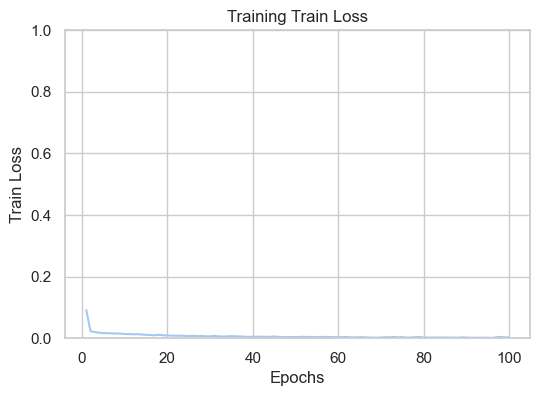

Epoch 1 Test


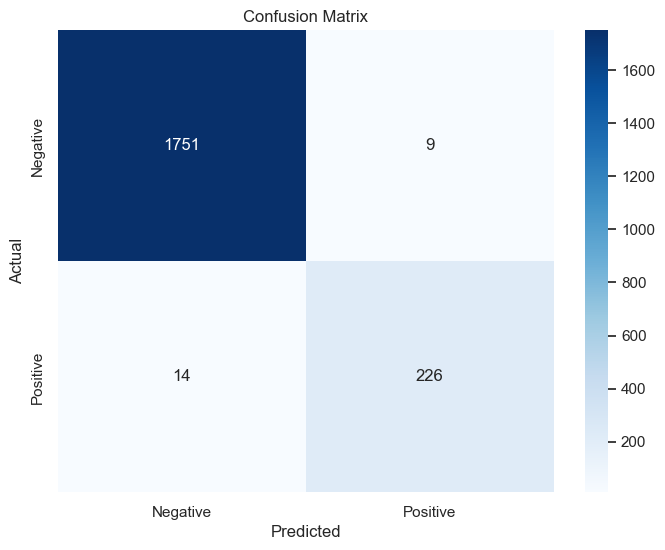

In [22]:
# SC - added store_data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 100
# Not saving.
save_factor = 1000
model_ep3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_ep3.test(test_loader)
plot_metrics(model_ep3.train_loss, len(model_ep3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_ep3.test_predicted)

# Dense Layer Size at 0.01 Learning Rate and 10 Epochs

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model_fc1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 161.86batch/s]


Epoch [1/10], Train Loss: 0.0906, Train Acc: 0.9640, Train F1: 0.9557


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 162.09batch/s]


Epoch [2/10], Train Loss: 0.0222, Train Acc: 0.9908, Train F1: 0.9907


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 146.03batch/s]


Epoch [3/10], Train Loss: 0.0200, Train Acc: 0.9918, Train F1: 0.9917


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 160.78batch/s]


Epoch [4/10], Train Loss: 0.0179, Train Acc: 0.9921, Train F1: 0.9920


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 141.86batch/s]


Epoch [5/10], Train Loss: 0.0175, Train Acc: 0.9928, Train F1: 0.9927


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 163.19batch/s]


Epoch [6/10], Train Loss: 0.0167, Train Acc: 0.9926, Train F1: 0.9925


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 158.86batch/s]


Epoch [7/10], Train Loss: 0.0163, Train Acc: 0.9933, Train F1: 0.9933


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 169.39batch/s]


Epoch [8/10], Train Loss: 0.0165, Train Acc: 0.9921, Train F1: 0.9920


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 168.72batch/s]


Epoch [9/10], Train Loss: 0.0152, Train Acc: 0.9936, Train F1: 0.9935


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 165.74batch/s]


Epoch [10/10], Train Loss: 0.0161, Train Acc: 0.9923, Train F1: 0.9923


Testing: 100%|██████████| 16/16 [00:00<00:00, 192.11batch/s]


Test Loss: 0.0296, Test Accuracy: 0.9890, Test F1: 0.9891


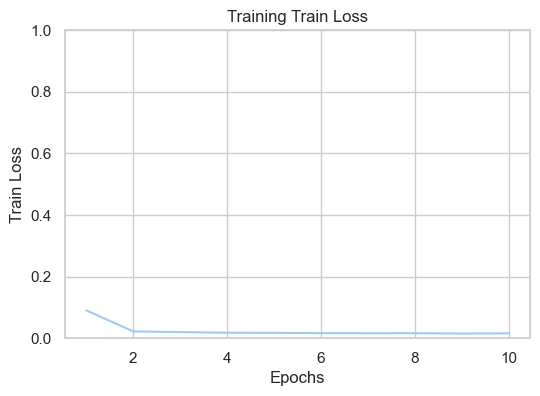

Epoch 1 Test


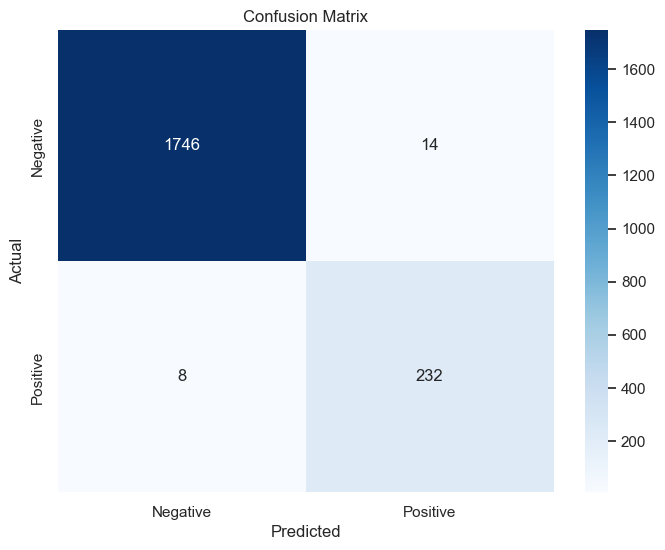

In [24]:
# SC - added store_data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_fc1.test(test_loader)
plot_metrics(model_fc1.train_loss, len(model_fc1.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc1.test_predicted)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 1024
save_dir = './Models/saved_models/'
model_fc2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 139.42batch/s]


Epoch [1/10], Train Loss: 0.0665, Train Acc: 0.9730, Train F1: 0.9680


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 127.40batch/s]


Epoch [2/10], Train Loss: 0.0204, Train Acc: 0.9901, Train F1: 0.9900


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 142.80batch/s]


Epoch [3/10], Train Loss: 0.0183, Train Acc: 0.9916, Train F1: 0.9915


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 139.39batch/s]


Epoch [4/10], Train Loss: 0.0179, Train Acc: 0.9912, Train F1: 0.9911


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 139.89batch/s]


Epoch [5/10], Train Loss: 0.0169, Train Acc: 0.9917, Train F1: 0.9916


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 149.72batch/s]


Epoch [6/10], Train Loss: 0.0185, Train Acc: 0.9913, Train F1: 0.9912


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 152.70batch/s]


Epoch [7/10], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9912


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 156.67batch/s]


Epoch [8/10], Train Loss: 0.0154, Train Acc: 0.9918, Train F1: 0.9917


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 158.20batch/s]


Epoch [9/10], Train Loss: 0.0146, Train Acc: 0.9934, Train F1: 0.9933


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 152.48batch/s]


Epoch [10/10], Train Loss: 0.0143, Train Acc: 0.9926, Train F1: 0.9925


Testing: 100%|██████████| 16/16 [00:00<00:00, 216.70batch/s]


Test Loss: 0.0278, Test Accuracy: 0.9878, Test F1: 0.9877


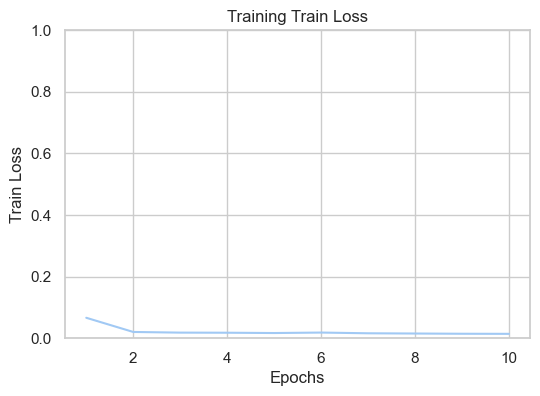

Epoch 1 Test


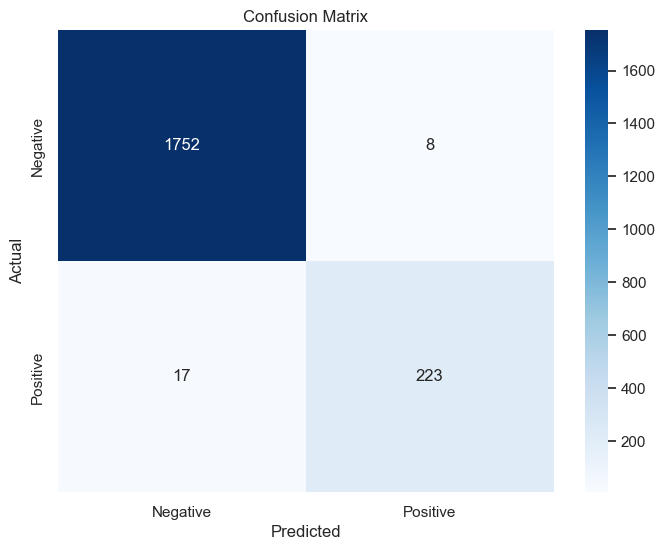

In [26]:
# SC - Added store_data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_fc2.test(test_loader)
plot_metrics(model_fc2.train_loss, len(model_fc2.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc2.test_predicted)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 2048
save_dir = './Models/saved_models/'
model_fc3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10:   0%|          | 0/63 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 112.28batch/s]


Epoch [1/10], Train Loss: 0.0566, Train Acc: 0.9768, Train F1: 0.9729


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 161.07batch/s]


Epoch [2/10], Train Loss: 0.0201, Train Acc: 0.9906, Train F1: 0.9905


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 177.65batch/s]


Epoch [3/10], Train Loss: 0.0195, Train Acc: 0.9900, Train F1: 0.9899


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 175.89batch/s]


Epoch [4/10], Train Loss: 0.0183, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 167.69batch/s]


Epoch [5/10], Train Loss: 0.0176, Train Acc: 0.9912, Train F1: 0.9911


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 164.50batch/s]


Epoch [6/10], Train Loss: 0.0179, Train Acc: 0.9908, Train F1: 0.9908


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 118.94batch/s]


Epoch [7/10], Train Loss: 0.0161, Train Acc: 0.9916, Train F1: 0.9915


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 178.51batch/s]


Epoch [8/10], Train Loss: 0.0163, Train Acc: 0.9926, Train F1: 0.9925


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 181.52batch/s]


Epoch [9/10], Train Loss: 0.0140, Train Acc: 0.9928, Train F1: 0.9928


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 180.60batch/s]


Epoch [10/10], Train Loss: 0.0136, Train Acc: 0.9928, Train F1: 0.9927


Testing: 100%|██████████| 16/16 [00:00<00:00, 230.70batch/s]

Test Loss: 0.0338, Test Accuracy: 0.9890, Test F1: 0.9889


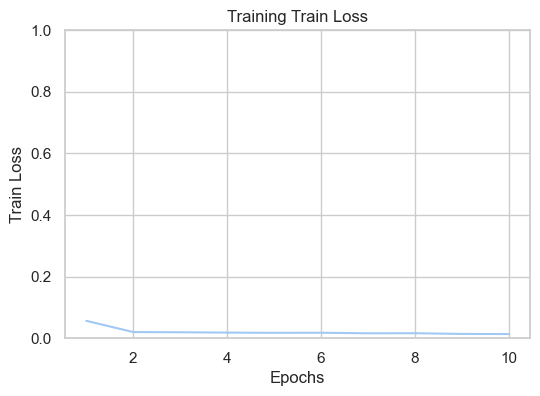

Epoch 1 Test


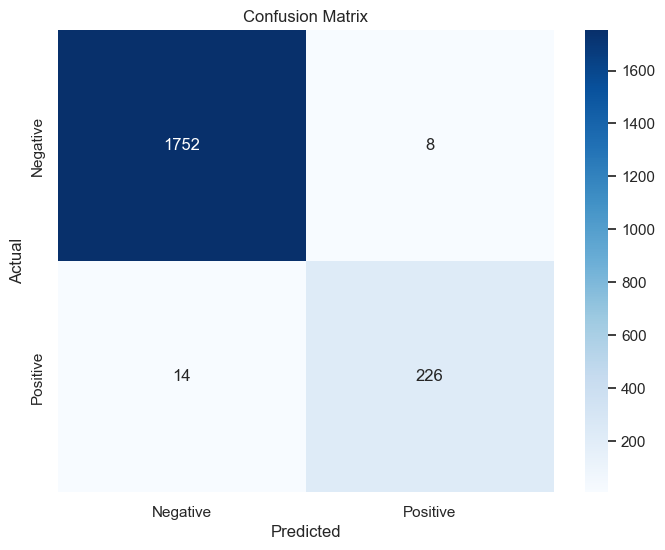

In [28]:
# SC - added store_data parameter to model creation

sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_fc3.test(test_loader)
plot_metrics(model_fc3.train_loss, len(model_fc3.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc3.test_predicted)

# SHAP Comparison

# None seem to have a significant impact provided we sample through the explainer.

Learning Rate

In [ ]:
# SC- run time was 1m 8.9s

model_lr1 = model_lr1.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# LR 0.1
xp_lr1 = shap.GradientExplainer(model_lr1, X_test_tensor)
x = xp_lr1.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 11.1s

model_lr2 = model_lr2.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# LR 0.01
xp_lr2 = shap.GradientExplainer(model_lr2, X_test_tensor)
x = xp_lr2.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 11.2s

model_lr3 = model_lr3.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# LR 0.001
xp_lr3 = shap.GradientExplainer(model_lr3, X_test_tensor)
x = xp_lr3.shap_values(X_test_tensor)

Epochs

In [ ]:
# SC- run time was 1m 11.5s

model_ep1 = model_ep1.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# Epochs 10
xp_ep1 = shap.GradientExplainer(model_ep1, X_test_tensor)
x = xp_ep1.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 11.6s

model_ep2 = model_ep2.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# Epochs 50
xp_ep2 = shap.GradientExplainer(model_ep2, X_test_tensor)
x = xp_ep2.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 11.2s

model_ep3 = model_ep3.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# Epochs 100
xp_ep3 = shap.GradientExplainer(model_ep3, X_test_tensor)
x = xp_ep3.shap_values(X_test_tensor)

Dense Layers - this seems to increase complexity with layer size.

In [ ]:
# SC- run time was 1m 11.2s

model_fc1 = model_fc1.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# FC 128
xp_fc1 = shap.GradientExplainer(model_fc1, X_test_tensor)
x = xp_fc1.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 13.8s

model_fc2 = model_fc2.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# FC 1024
xp_fc2 = shap.GradientExplainer(model_fc2, X_test_tensor)
x = xp_fc2.shap_values(X_test_tensor)

In [ ]:
# SC- run time was 1m 17.2s

model_fc3 = model_fc3.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# FC 2048
xp_fc3 = shap.GradientExplainer(model_fc3, X_test_tensor)
x = xp_fc3.shap_values(X_test_tensor)

One more extreme layer. - Yes it does increase time.

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 8192
save_dir = './Models/saved_models/'
model_fc4 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 112.12batch/s]


Epoch [1/10], Train Loss: 0.0578, Train Acc: 0.9793, Train F1: 0.9764


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 172.21batch/s]


Epoch [2/10], Train Loss: 0.0223, Train Acc: 0.9886, Train F1: 0.9885


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 171.12batch/s]


Epoch [3/10], Train Loss: 0.0202, Train Acc: 0.9908, Train F1: 0.9907


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 169.97batch/s]


Epoch [4/10], Train Loss: 0.0177, Train Acc: 0.9922, Train F1: 0.9921


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 160.20batch/s]


Epoch [5/10], Train Loss: 0.0162, Train Acc: 0.9921, Train F1: 0.9920


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 149.55batch/s]


Epoch [6/10], Train Loss: 0.0194, Train Acc: 0.9909, Train F1: 0.9908


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 152.21batch/s]


Epoch [7/10], Train Loss: 0.0167, Train Acc: 0.9918, Train F1: 0.9918


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 156.10batch/s]


Epoch [8/10], Train Loss: 0.0150, Train Acc: 0.9928, Train F1: 0.9928


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 134.68batch/s]


Epoch [9/10], Train Loss: 0.0149, Train Acc: 0.9923, Train F1: 0.9923


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 141.74batch/s]


Epoch [10/10], Train Loss: 0.0132, Train Acc: 0.9938, Train F1: 0.9937


Testing: 100%|██████████| 16/16 [00:00<00:00, 219.56batch/s]

Test Loss: 0.0325, Test Accuracy: 0.9865, Test F1: 0.9864


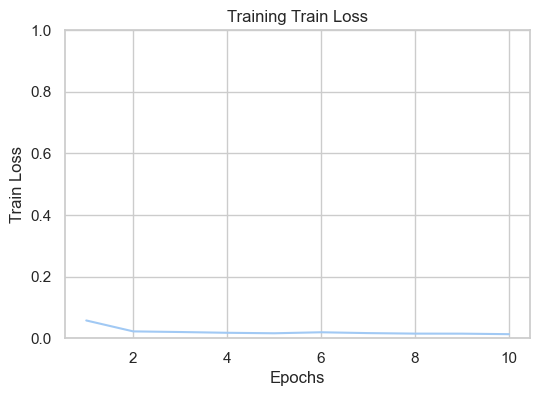

Epoch 1 Test


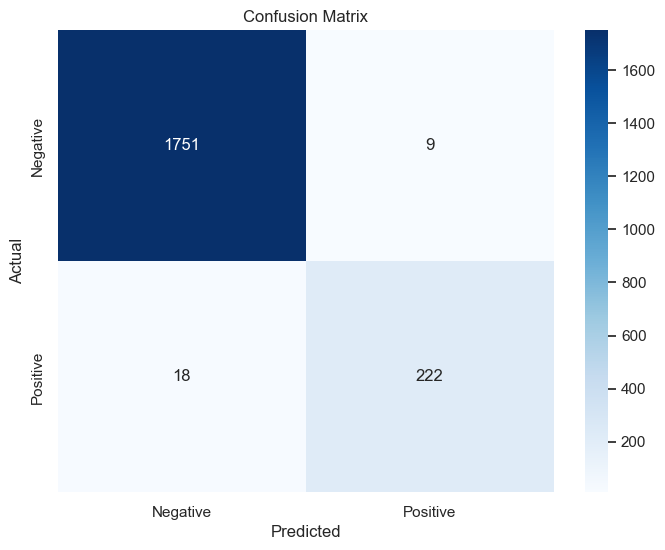

In [39]:
# SC - added store_data parameter added to model creation.

sampler = None
params = None
learning_rate = 0.01
epochs = 10
# Not saving.
save_factor = 100
model_fc4.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model_fc4.test(test_loader)
plot_metrics(model_fc4.train_loss, len(model_fc4.train_loss), title="Train Loss")
print('Epoch 1 Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model_fc4.test_predicted)

In [ ]:
# SC- run time was 1m 33.5s

model_fc4 = model_fc4.cpu() # Model needed to be moved back to the CPU for SHAP calculation.

# FC 8192
xp_fc4 = shap.GradientExplainer(model_fc4, X_test_tensor)
x = xp_fc4.shap_values(X_test_tensor)

# Random Forest

Number of Estimators directly impacts the length of shap calculation along with the probability of shapely values calculating up to the baseline.

500 estimators

In [ ]:
# SC- run time was 1m 33.5s

rf1 = RandomForestClassifier(n_estimators=500, random_state=42)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
xp_rf1 = shap.TreeExplainer(rf1, X_test)
# Sparse data error.
x = xp_rf1.shap_values(X_test, check_additivity=False)

 99%|===================| 3958/4000 [01:25<00:00]        

In [ ]:
# SC- run time was 1m 33.5s

rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
xp_rf2 = shap.TreeExplainer(rf2, X_test)
# Sparse data error.
x = xp_rf2.shap_values(X_test, check_additivity=False)

 95%|=================== | 3809/4000 [00:16<00:00]       

In [ ]:
# SC- run time was 1.8s

rf3 = RandomForestClassifier(n_estimators=10, random_state=42)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)
xp_rf3 = shap.TreeExplainer(rf3, X_test)
x = xp_rf3.shap_values(X_test)